In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit


def euclid_distance(p1, p2):
    return np.linalg.norm(p1 - p2, 2)


def all_distances(x1, x2):
    d = np.zeros((x1.shape[0], x2.shape[0]))
    for idx1 in range(len(x1)):
        for idx2 in range(len(x2)):
            d[idx1, idx2] = euclid_distance(x1[idx1, :], x2[idx2, :])
    return d



def linear_binary_class(n, low_d, high_d, m, q):
    x = np.zeros((n, 2))
    y = np.zeros(n)
    for i in range(2):
        x[:, i] = np.random.uniform(low_d, high_d, size=n)

    y[x[:, 1] - (x[:, 0] * m + q) > 0] = 1
    y[x[:, 1] - (x[:, 0] * m + q) < 0] = -1

    return x, y


def flip_labels(y, p):
    if p < 1 or p > 100:
        print("Процент должен быть от 0 до 10p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    y_noisy = np.copy(np.squeeze(y))
    if y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = y_noisy.size
    n_flips = int(np.floor(n * p / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    y_noisy[idx_to_flip] = -y_noisy[idx_to_flip]

    return y_noisy


def calc_error_svm(y_pred, y_true):
    cnt = 0
    for i in range(len(y_true)):
        if y_pred[i] * y_true[i] < 1:
            cnt += 1
    return cnt / len(y_true)


def svm_predict(xtr, ytr, xte, reg_parm=0.1, epochs=1000):
    n_train, d_train = np.shape(xtr)

    if any(np.abs(ytr) != 1):
        print("Значение должно быть +1 или -1.")
        return -1

    w = np.zeros(d_train)

    for epoch in range(1, epochs):
        learning_rate = 1 / epoch
        for i, x in enumerate(xtr):
            if (ytr[i] * np.dot(xtr[i], w)) < 1:
                w = (1 - learning_rate) * w + learning_rate * reg_parm * ytr[i] * xtr[i]
            else:
                w = (1 - learning_rate) * w

    y_pred = np.dot(xte, w)

    return y_pred, w


def svm_train_test_analysis(x_tr, y_tr, x_te, y_te, reg_params):
    train_err = np.zeros(np.shape(reg_params))
    test_err = np.zeros(np.shape(reg_params))

    for i in range(len(reg_params)):
        ypredt, w_train = svm_predict(x_tr, y_tr, x_tr, reg_params[i])
        train_err[i] = calc_error_svm(ypredt, y_tr)

        ypredtr, w_pred = svm_predict(x_tr, y_tr, x_te, reg_params[i])
        test_err[i] = calc_error_svm(ypredtr, y_te)

    return train_err, test_err


def k_fold_cross_validation_svm(X, Y, num_of_folds, reg_param_list):
    if 0 >= num_of_folds >= 100 and isinstance(num_of_folds, int):
        print("select an integer in between 1 and 100")
        return -1

    size_of_input = X.shape[0]
    size_of_validation = int(np.ceil(size_of_input / num_of_folds))

    num_reg_param = len(reg_param_list)
    reg_param_list = np.array(reg_param_list)

    t_mean, t_sd, v_mean, v_sd = np.zeros(num_reg_param), \
                                 np.zeros(num_reg_param), \
                                 np.zeros(num_reg_param), \
                                 np.zeros(num_reg_param)

    random_index = np.random.choice(size_of_input, size=size_of_input, replace=False)

    for reg_index, reg_param in enumerate(reg_param_list):
        first = 0
        for fold in range(num_of_folds):
            flags = np.zeros(size_of_input)
            flags[first:first + size_of_validation] = 1

            x_training, y_training = X[flags == 0], Y[flags == 0]
            x_validation, y_validation = X[flags == 1], Y[flags == 1]

            y_train_predict, w = svm_predict(x_training, y_training, x_training, reg_param)
            training_error = calc_error_svm(y_train_predict, y_training)

            t_mean[reg_index] += training_error
            t_sd[reg_index] += training_error ** 2

            y_validation_predict, w = svm_predict(x_training, y_training, x_validation, reg_param)
            validation_error = calc_error_svm(y_validation_predict, y_validation)

            v_mean[reg_index] += validation_error
            v_sd[reg_index] += validation_error ** 2

            first += size_of_validation

    t_mean = t_mean / num_of_folds
    t_sd = t_sd / num_of_folds - t_mean ** 2

    v_mean = v_mean / num_of_folds
    v_sd = v_sd - v_mean ** 2

    best_reg_param_index = np.argmin(v_mean)
    best_reg_param = reg_param_list[best_reg_param_index]

    return best_reg_param, t_mean, t_sd, v_mean, v_sd

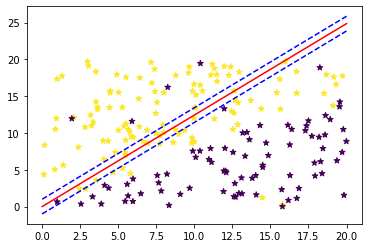

100 [0.24981155 0.14495703 0.13018242 0.07990351] [0.127388   0.04614565 0.03689403 0.01332773]


In [ ]:
X, Y = linear_binary_class(200, 0, 20, 0.8, 0)
Y = flip_labels(Y, 5)

training_percentage = 70
size_of_input_data = X.shape[0]

Xtr = X[0: (int(size_of_input_data * training_percentage / 100)), :]
Ytr = Y[0: (int(size_of_input_data * training_percentage / 100))]
Xte = X[(int(size_of_input_data * training_percentage / 100)):, :]
Yte = Y[(int(size_of_input_data * training_percentage / 100)):]

reg_param = 40
y_pred, w = svm_predict(Xtr, Ytr, Xte, reg_param)

plt.scatter(np.array(X[:, 0]), np.array(X[:, 1]), marker='*', c=Y)

a = -w[0] / w[1]
xx = np.linspace(0, 20)
yy = a * xx

plt.plot(xx, yy, color='red')

plt.plot(xx, (yy + 1), linestyle='--', color='blue')
plt.plot(xx, (yy - 1), linestyle='--', color='blue')

plt.show()

reg_param_range = [10, 40, 70, 100]
number_of_folds = 3
best_reg_param, T_mean, T_sd, V_mean, V_sd = k_fold_cross_validation_svm(X, Y, number_of_folds, reg_param_range)
print(best_reg_param, V_mean, V_sd)

Time taken to complete process: 16.833899328000143
[1.         1.         0.71428571 0.38571429 0.3        0.07142857
 0.1        0.08571429 0.29285714 0.29285714 0.29285714]


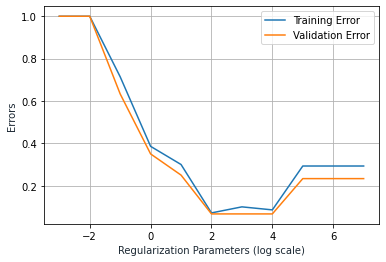

[1.         1.         0.63333333 0.35       0.25       0.06666667
 0.06666667 0.06666667 0.23333333 0.23333333 0.23333333]


In [ ]:
reg_params = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]

start_time = timeit.default_timer()

train_errors, validation_errors = svm_train_test_analysis(Xtr, Ytr, Xte, Yte, reg_params)

end_time = timeit.default_timer()

print('Time taken to complete process:', end_time - start_time)
print(train_errors)

plt.plot(np.log10(np.array(reg_params)), np.array(train_errors), label='Training Error')
plt.plot(np.log10(np.array(reg_params)), np.array(validation_errors), label='Validation Error')
plt.xlabel('Regularization Parameters (log scale)', color='#1C2833')
plt.ylabel('Errors', color='#1C2833')
plt.legend(loc='upper right')
plt.grid()
plt.show()

print(validation_errors)